<a href="https://www.kaggle.com/code/jesu123/rnns-lstm-gru-on-stock-prediction-dataset?scriptVersionId=220474480" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-2006-01-01-to-2018-01-01/IBM_2006-01-01_to_2018-01-01.csv


In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
import pandas as pd

Using TensorFlow backend.

In [4]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

# We will be using RMSE to test our model
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
# First, we get the data
##df= pd.read_csv("/kaggle/input/ibm-2006-01-01-to-2018-01-01/IBM_2006-01-01_to_2018-01-01.csv", index_col= 'Date')
##df.head()

dataset = pd.read_csv('/kaggle/input/ibm-2006-01-01-to-2018-01-01/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [6]:
# We are only considering HIGH values
dataset[:'2006-01'].iloc[:,1:2]

,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90
2006-01-06,85.03
2006-01-09,84.25
2006-01-10,84.12
2006-01-11,84.81
2006-01-12,83.96
2006-01-13,83.45


In [7]:
# All data till 2016 in training and rest in test[ONLY HIGH values]
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

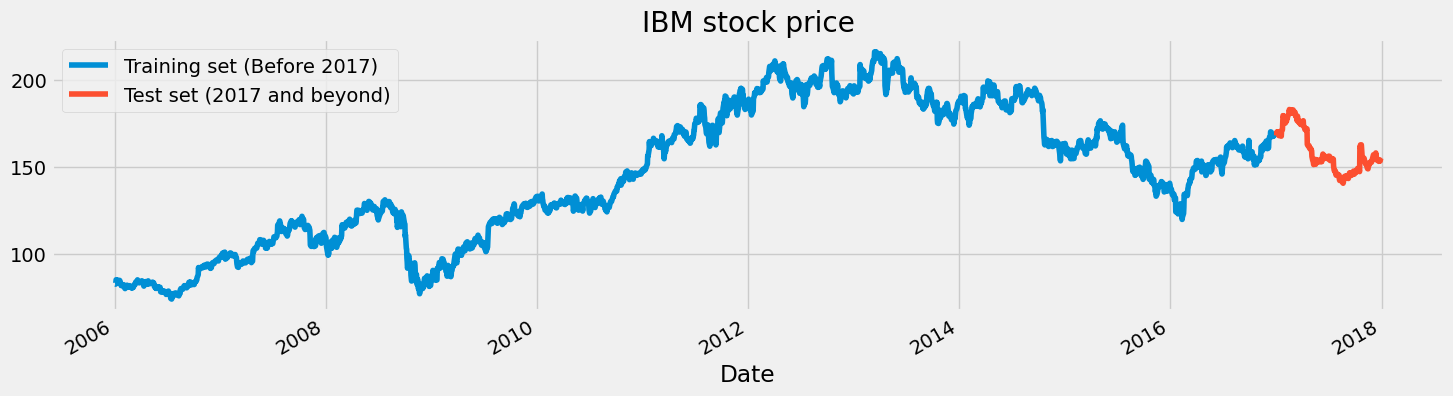

In [8]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
training_set_scaled.shape

(2769, 1)

In [11]:
# Since LSTMs store long term memory state, 
# we create a data structure with 60 timesteps and 1 output
# So for each element of training set,
# we have 60 previous training set elements 

X_train = []
y_train = []
for i in range(60,2769):
#     print(i-60,i)
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
training_set_scaled[0:11,0]

array([0.06065089, 0.06029868, 0.06311637, 0.0781206 , 0.07262609,
       0.07171034, 0.07657087, 0.07058326, 0.0669907 , 0.06494787,
       0.075796  ])

In [13]:
training_set_scaled[10,0]

0.07579599887292199

In [14]:
print(X_train.shape[0],X_train.shape[1])

2709 60


In [15]:
print(X_train.shape)

(2709, 60)


In [16]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [17]:
X_train.shape

(2709, 60, 1)

In [18]:
X_train[0].shape

(60, 1)

In [19]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=20,batch_size=32,verbose=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - loss: 0.0536
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0109
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0084
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0061
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0061
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0055
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0050
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0040
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0037
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0039
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0042
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0035
Epoch 13/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0039
Epoch 14/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.0033
Epoch 15/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0034
Ep

In [20]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [21]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


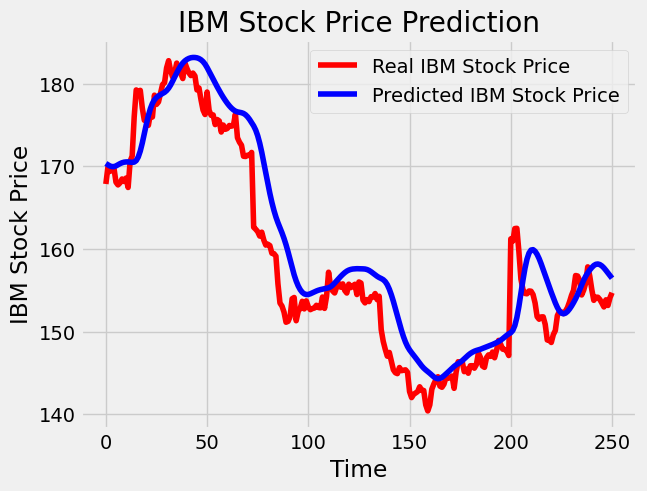

In [22]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [23]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.316938917560466.


## GRU architecture

In [24]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - loss: 0.1626
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 0.0339
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0068
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0043
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 0.0040
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 0.0039
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 0.0034
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0032
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.0032
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.0029
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.0031
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - loss: 0.0031
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0027
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - loss: 0.0024
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 0.0025


In [25]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [26]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


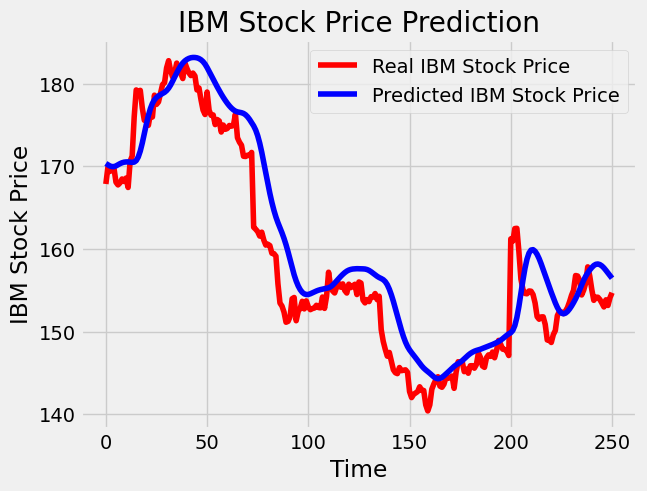

In [27]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [28]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.316938917560466.


# The GRU architecture

In [29]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - loss: 0.1652
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0493
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0165
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 0.0057
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 0.0046
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 0.0042
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0034
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 0.0039
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0035
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 0.0033
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 0.0033
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - loss: 0.0030
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 0.0031
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.0030
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0028

In [30]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


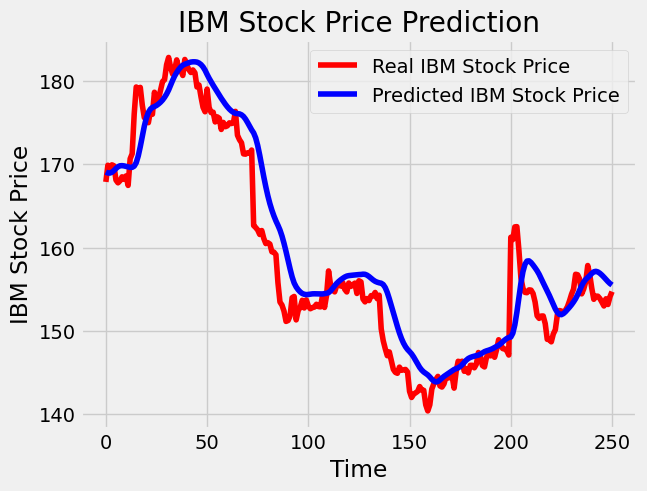

In [31]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [32]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.712884540112336.


In [33]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

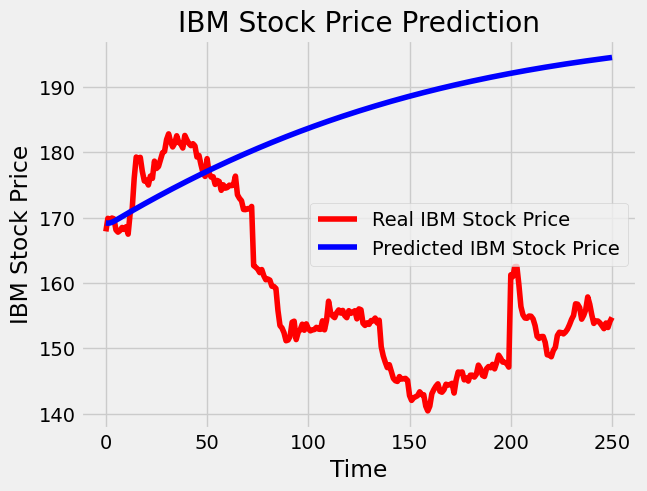

In [34]:
# Visualizing the sequence
plot_predictions(test_set,sequence)


In [35]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 32.17968639802733.
